# Creating your own EOF code
#### by Elizabeth Barnes

Demonstration of how to code up EOF analysis from start to finish.

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

#.............................................
# IMPORT STATEMENTS
#.............................................
import numpy as np
import matplotlib.pyplot as plt
import importlib
import scipy.stats as stats
import numpy.linalg as LA
import scipy.io as sio
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon

import general_functions as gf
importlib.reload(gf)
gf.add_parent_dir_to_path()

from lib import class_general_functions as cgf
importlib.reload(cgf)

#.............................................
# PLOTTING COMMANDS
#.............................................
gf.cc()
plt.ioff()

This is a place for user input. Which EOF do you want to plot?

In [2]:
#-------------------------------------
# which EOF do you want to plot?
eof_num = 1
#-------------------------------------

### Data Description

This data is composed of 7 weather variables averaged over one year for each state in the US (thus, 50 states). There is also an option to comment this out and instead use a matrix of random data (just for comparison).

In [3]:
# names of the different variables for each state
descriptor_names = ['temp','precip','% sun','sun hours','clear dys','humid AM','humid PM']

# load the data
DATA = sio.loadmat('data/state_data_raw.mat')
Y = DATA['X']

# UNCOMMENT if you want to use RANDOM data
Y = np.random.rand(np.size(Y,axis=0),np.size(Y,axis=1))

### Process your data into anomalies and decide whether to standardize or not

One decision you need to make is whether you wish to standardize your data. In this example, the 7 weather variables all have very different units. Thus, if you don't standardize your data the variable with the largest units will likely dominate the EOF calculation - and this is obviously not what we want. So, I standardize. However, note you can uncomment one of the lines if you want to see what happens when you do not standardize.

In [4]:
# calculate anomalies from the state-mean (sample-mean) - call this "X"
Ymean = np.nanmean(Y,axis = 0)
X = Y - Ymean

In [5]:
# remove any NaNs
i = np.isnan(X)
X[i] = 0. # this step does not make a lot of sense!!

In [6]:
# standardize the data - call it "Xw"
Xstd = np.std(X,axis = 0)
Xw = X/Xstd

# UNCOMMENT if you don't want to standardize the data
#Xw = X;

### Calculate EOF using temporal covariance matrix (covariance along the sampling dimension)

In [7]:
# calculate the temporal covariance matrix, dimensions should be [variable x variable]
C = 1./np.size(X,axis = 0)*np.dot(np.transpose(Xw),Xw)

# calculate eigenvalues and eigenvectors of C
lam, E = LA.eig(C)

# sort eigenvalues and vector by the largest to smallest eigenvalues
i = np.flipud(np.argsort(lam))
lam = lam[i]
E = E[:,i]

In [8]:
# convert eigenvalues to percent variance explained
pve = 100.*lam/np.sum(lam)

### Calculate PC timeseries and scaled EOF (called "d")

In [9]:
# take only one eigenvector, user specified by "eof_num" above
e1 = E[:,eof_num-1]

# calculate the the PC associated with the EOF of interest
z1 = np.dot(Xw,e1)

# standardize z1
z1 = (z1-np.mean(z1))/np.std(z1)

# calculate d1 for plotting in physical units, not standardized/weighted units,
# thus it uses the original "X" anomaly data
d1 = (1./np.size(X,axis=0))*np.dot(np.transpose(z1),X)

# calculate d1 for plotting in standardized/weighted units,
# thus it uses the "Xw" anomaly data
d1s = (1./np.size(Xw, axis = 0))*np.dot(np.transpose(z1),Xw)

### Plot the results: eigenvalue spectrum

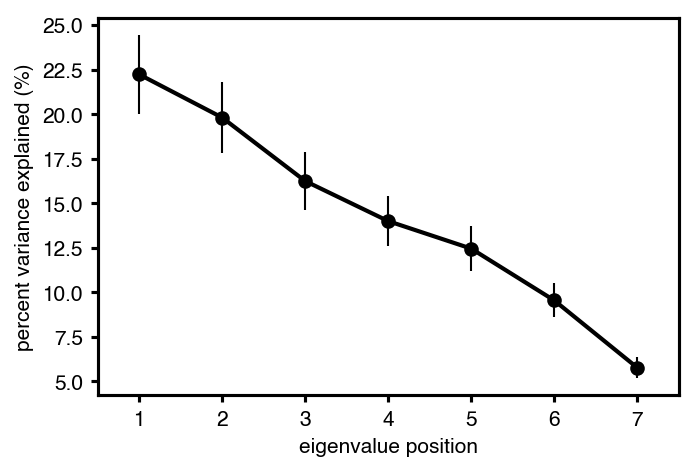

In [10]:
cgf.cfig(1)
plt.plot(np.arange(1,np.size(pve)+1.),pve,'o-',linewidth = 2, color = 'black')

plt.xlim(0.5, 7.5)
plt.xlabel('eigenvalue position')
plt.ylabel('percent variance explained (%)')

# plot error bars according to North et al.abs
# here we will assume that all of the data is independent (is that a good assumption?)
# such that Nstar = N
Nstar = np.size(X,axis = 0)
eb = pve*np.sqrt(2./Nstar)
plt.errorbar(np.arange(1,np.size(pve)+1.),pve,yerr = eb/2, xerr = None, linewidth = 1, color = 'black')

plt.show()

### Plot the results: EOF in standardized units

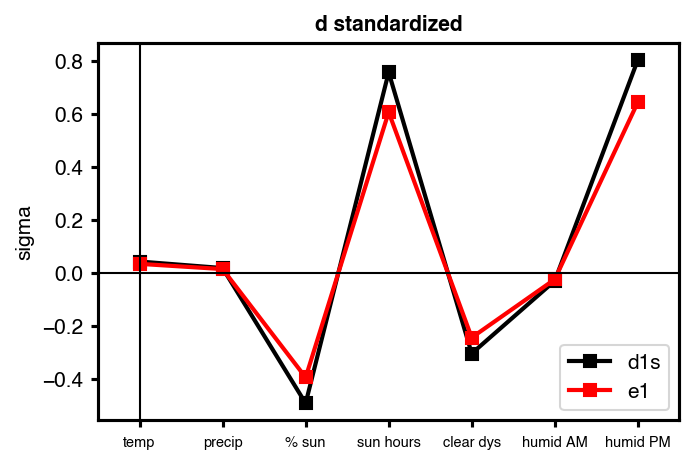

In [11]:
cgf.cfig(2)
plt.plot(d1s,'s-k',linewidth = 2, label = 'd1s')
plt.plot(e1,'s-r',linewidth = 2, label = 'e1')

plt.xticks(np.arange(len(descriptor_names)),descriptor_names, fontsize = 7)
plt.xlim(-0.5, 6.5)

plt.legend()
gf.plot_zero_lines()
plt.ylabel('sigma')
plt.title('d standardized')

plt.show()

### Plot the results: EOF in physical units

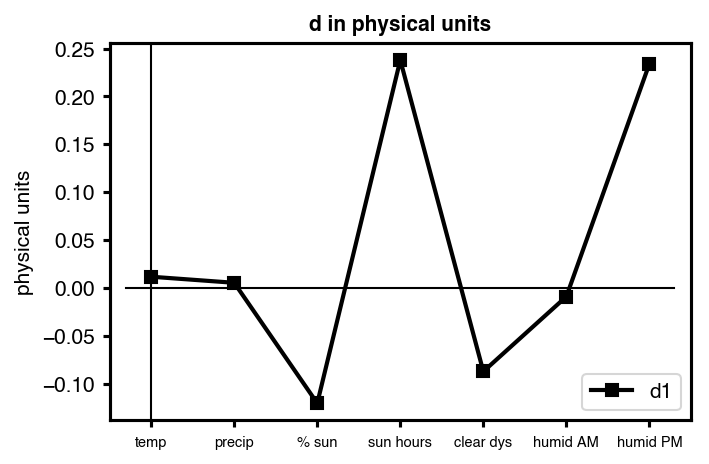

In [12]:
cgf.cfig(3)
plt.plot(d1,'s-k',linewidth = 2, label = 'd1')

plt.xticks(np.arange(len(descriptor_names)),descriptor_names, fontsize = 7)
gf.plot_zero_lines()
plt.legend()
plt.ylabel('physical units')
plt.title('d in physical units')
plt.xlim(-0.5, 6.5)

plt.show()

### Plot the results: PC as a U.S. map

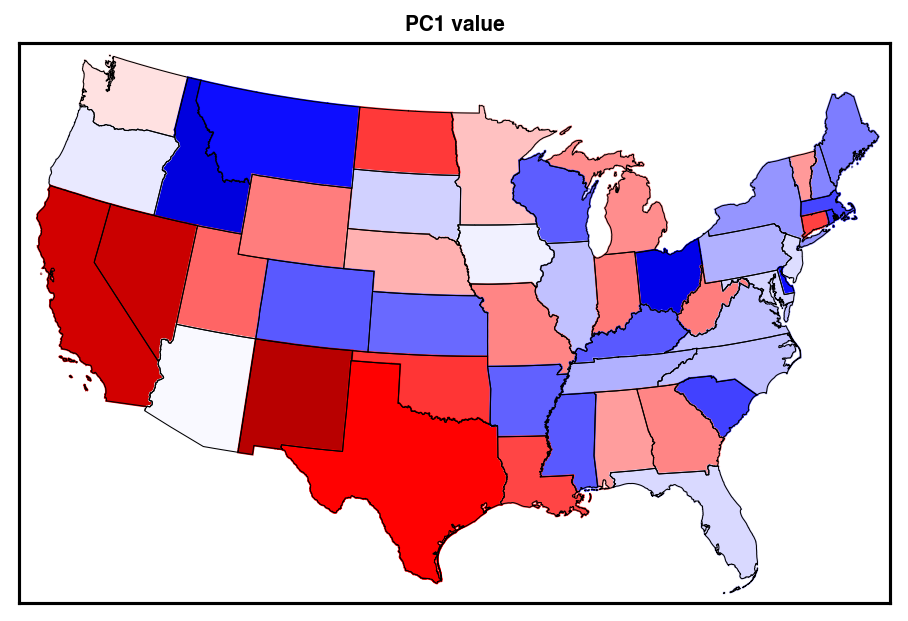

In [13]:
cgf.cfig(4, fig_width = cgf.fig_width*1.5, fig_height = cgf.fig_height*1.5)

# create the map
m = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
        projection='lcc',lat_1=33,lat_2=45,lon_0=-95)

# load the shapefile, use the name 'states'
m.readshapefile('data/st99_d00', name='states', drawbounds=True)

# collect the state names from the shapefile attributes so we can
# look up the shape obect for a state by it's name
state_names = []
for shape_dict in m.states_info:
    state_names.append(shape_dict['NAME'])

state_names_list = sorted(list(set(state_names)))
state_names_list.pop(state_names_list.index('District of Columbia'))
state_names_list.pop(state_names_list.index('Puerto Rico'))

ax = plt.gca() # get current axes instance

colors={}
cmap = plt.cm.get_cmap('seismic')
vmin = -3.
vmax = 3.

for shapedict in m.states_info:
    statename = shapedict['NAME']
    # skip DC and Puerto Rico.
    if statename not in ['District of Columbia','Puerto Rico']:
        z = z1[state_names_list.index(statename)]
        # calling colormap with value between 0 and 1 returns
        # rgba value.  Invert color range (hot colors are high
        # population), take sqrt root to spread out colors more.
        colors[statename] = cmap((z-vmin)/(vmax-vmin))[:3]

for nshape,seg in enumerate(m.states):
    # skip DC and Puerto Rico.
    if state_names[nshape] not in ['District of Columbia','Puerto Rico', 'Alaska', 'Hawaii']:
        color = colors[state_names[nshape]]
        
        poly = Polygon(seg,facecolor=color,edgecolor=color)
        ax.add_patch(poly)

        
plt.title('PC' + str(eof_num) + ' value')

plt.show()

These PC values show how much a given state "looks" like the EOF structure above. Dark blue and dark red denote large opposite signed values (remember, the sign itself doesn't matter here - just the relationships between values/signs across states).